Working with the [Ames House Price](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) dataset from Kaggle. The task is to train the multiclass prediction model of the house prices using Catboost regression. Also the task is to compare the training efficiency when using data with and without missing values.

In [2]:
import pandas as pd
import numpy as np

from pathlib import Path
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from catboost import CatBoostRegressor, Pool
from impyute.imputation.cs import mice

pd.options.mode.chained_assignment = None
%matplotlib inline

In [3]:
DATA_PATH = Path(r'C:\Users\natal\OneDrive\Рабочий стол\ML_notebooks\data\ames_house_prices')

In [4]:
df = pd.read_csv(DATA_PATH / 'train.csv')
df.index += 1
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Displaying all columns with missing values sorted in descending order of percentage_missing values

In [5]:
na_cols = df.columns[df.isna().any()]
na_df = pd.DataFrame(
    {
        'dtype' : df[na_cols].dtypes,
        'n_missing' : df[na_cols].isna().sum(),
        'percentage_missing' : df[na_cols].isna().sum()/len(df)
    }
)

na_df.sort_values(by='percentage_missing', ascending=False)

,dtype,n_missing,percentage_missing
PoolQC,object,1453,0.995205
MiscFeature,object,1406,0.963014
Alley,object,1369,0.937671
Fence,object,1179,0.807534
MasVnrType,object,872,0.597260
FireplaceQu,object,690,0.472603
LotFrontage,float64,259,0.177397
GarageType,object,81,0.055479
GarageYrBlt,float64,81,0.055479
GarageFinish,object,81,0.055479


Test remove of the columns with more than 25% of the dataframe length as missing values


In [6]:
na_lim = len(df) * 0.25
cols_to_drop = na_df.query('n_missing > @na_lim').index.tolist()
df.drop(cols_to_drop, axis=1).head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
2,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
3,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
4,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
5,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


Split dataframe into unbound and target samples

## Train the Catboost model with a DF with missing values

In [7]:
X = df[np.setdiff1d(df.columns, 'SalePrice')]
y = pd.DataFrame(df['SalePrice'])

Create variables for numerical and categorical features

In [8]:
cols_to_categorical = ['Id','MSSubClass','OverallCond','OverallQual']
X[cols_to_categorical] = X[cols_to_categorical].astype('object')

num_cols = X.select_dtypes('number').columns.tolist()
cat_cols = X.select_dtypes('object').columns.tolist()

Split data into train and test in proportion 80/20 and shuffle

In [9]:
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=42)

Fill in the missing values

In [10]:
X_train.fillna(value='missing', inplace=True)
X_test.fillna(value='missing', inplace=True)

In [ ]:
# X_train.fillna('None', inplace=True)
# X_test.fillna('None', inplace=True)

Launch the training of the catboost regression model with data with missing values

In [12]:
cb = CatBoostRegressor()
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols)
cb.fit(train_pool, eval_set=test_pool, verbose=200, plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.052178
0:	learn: 74706.0148723	test: 85037.2475015	best: 85037.2475015 (0)	total: 249ms	remaining: 4m 8s
200:	learn: 16226.3845628	test: 27018.9303201	best: 27018.9303201 (200)	total: 25s	remaining: 1m 39s
400:	learn: 11992.7501023	test: 26157.3891427	best: 26152.0198454 (399)	total: 50.1s	remaining: 1m 14s
600:	learn: 9717.2147664	test: 25882.6095877	best: 25880.3565163 (593)	total: 1m 15s	remaining: 49.9s
800:	learn: 8239.8058981	test: 25778.9990968	best: 25778.2840537 (799)	total: 1m 41s	remaining: 25.3s
999:	learn: 7127.8047573	test: 25674.9105426	best: 25664.3385526 (926)	total: 2m 6s	remaining: 0us

bestTest = 25664.33855
bestIteration = 926

Shrink model to first 927 iterations.


Plotting the loss values of the model for train and test samples

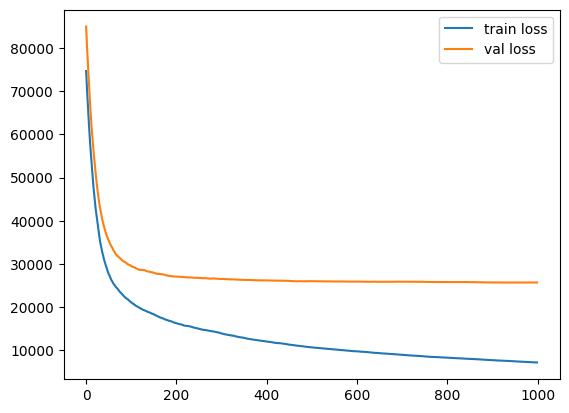

In [13]:
plt.plot(cb.get_evals_result()['learn']['RMSE'], label='train loss')
plt.plot(cb.get_evals_result()['validation']['RMSE'], label='val loss')
plt.legend()
plt.show()

Getting the best loss scores of the model


In [14]:
cb.get_best_score()

{'learn': {'RMSE': 7127.804757277984},
 'validation': {'RMSE': 25664.338552625577}}

Top-10 important features plotted with barplot

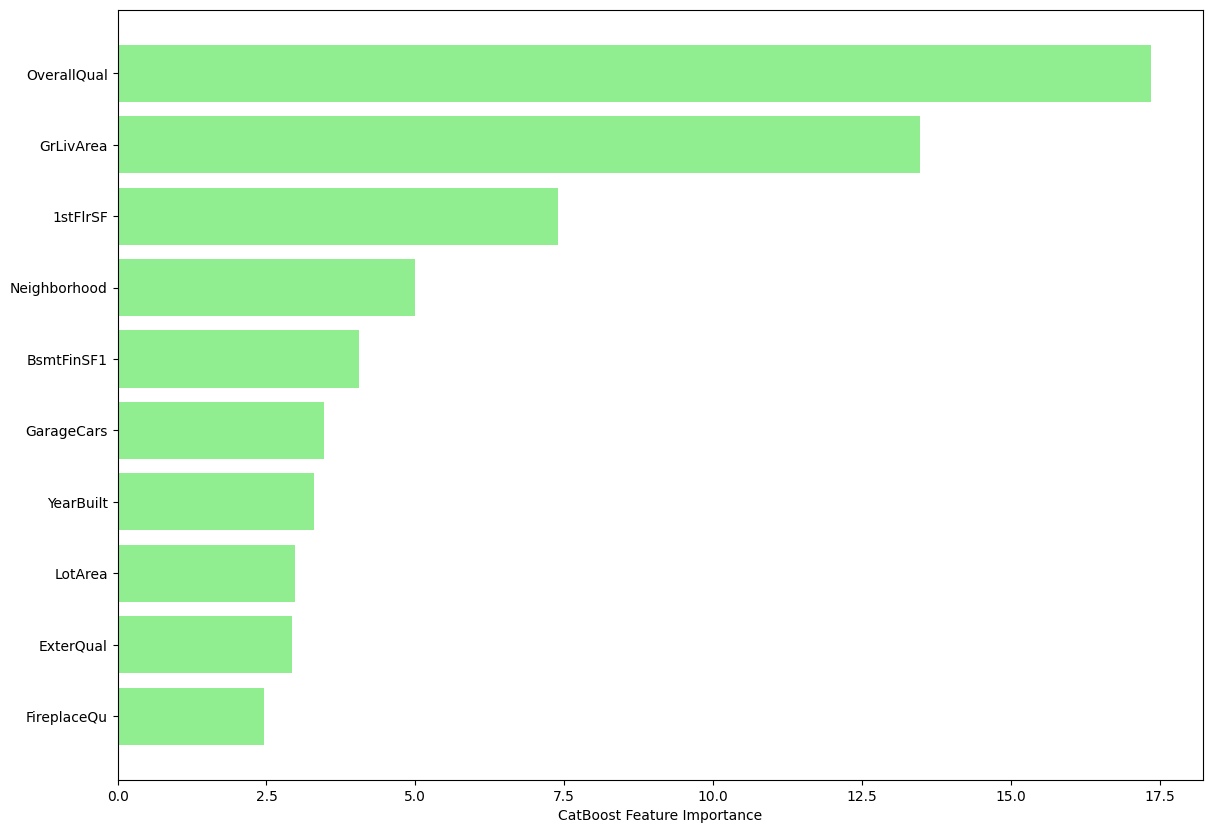

In [15]:
def feature_importance_plot(model, dataset, n_features=None):
    lim_n_features = n_features or len(dataset.get_feature_names())
    sorted_feature_importance = model.feature_importances_.argsort()
    
    sorted_features = np.array(dataset.get_feature_names())[sorted_feature_importance]
    sorted_importances = model.feature_importances_[sorted_feature_importance]
    
    plt.figure(figsize=(14, 10))
    plt.barh(sorted_features[-lim_n_features:], sorted_importances[-lim_n_features:], color='lightgreen')
    plt.xlabel("CatBoost Feature Importance")
    
    plt.show()
    
feature_importance_plot(cb, train_pool, n_features=10)

## Train the Catboost model with a DF without missing values

Drop the None / missing values

In [16]:
df_drop = df.drop(cols_to_drop, axis=1)

Split data into train and test in proportion 80/20 and shuffle

In [17]:
X_drop = df_drop[np.setdiff1d(df_drop.columns, 'SalePrice')]
y_drop = df_drop.SalePrice

X_drop_train, X_drop_test, y_drop_train, y_drop_test = train_test_split(X_drop, y_drop, test_size=test_size, 
                                                                        shuffle=True, random_state=42)

Using MICE, fill in the missing values in the numeric columns X_train, X_test. Once filled, the result must be converted back into a dataframe with appropriate column names

In [18]:
num_cols_Adrop = X_drop_train.select_dtypes('number').columns.to_list()

mice_imputer_train = mice(X_drop_train[num_cols_Adrop].values)
mice_imputer_test = mice(X_drop_test[num_cols_Adrop].values)

In [19]:
imputed_num_train_df = pd.DataFrame(mice_imputer_train, columns=num_cols_Adrop)
imputed_num_test_df = pd.DataFrame(mice_imputer_test, columns=num_cols_Adrop)

Fill in the missing values in the categorical columns with the highest frequency in the column using SimpleImputer from Sklearn.

In [20]:
cat_cols_Adrop = X_drop_train.select_dtypes('object').columns.to_list()

simple_imputer_freq = SimpleImputer(strategy='most_frequent')
simple_imputer_freq.fit(X_drop_train[cat_cols_Adrop])

SimpleImputer(strategy='most_frequent')

In [21]:
imputed_cat_train_df = pd.DataFrame(simple_imputer_freq.transform(X_drop_train[cat_cols_Adrop]), columns=cat_cols_Adrop)
imputed_cat_test_df = pd.DataFrame(simple_imputer_freq.transform(X_drop_test[cat_cols_Adrop]), columns=cat_cols_Adrop)

Concat the DFs with numerical and categorical features

In [22]:
imputed_train_df = pd.concat([imputed_num_train_df, imputed_cat_train_df], axis=1)
imputed_test_df = pd.concat([imputed_num_test_df, imputed_cat_test_df], axis=1)

Launch the training of the catboost regression model with data without missing values 

In [23]:
cb_imputed = CatBoostRegressor()
imputed_train_pool = Pool(imputed_train_df, y_drop_train, cat_features=cat_cols_Adrop)
imputed_test_pool = Pool(imputed_test_df, y_drop_test, cat_features=cat_cols_Adrop)

cb_imputed.fit(imputed_train_pool, eval_set=imputed_test_pool, verbose=200, plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.052178
0:	learn: 74703.6722666	test: 85116.0028767	best: 85116.0028767 (0)	total: 115ms	remaining: 1m 54s
200:	learn: 16041.6270302	test: 27324.2944991	best: 27324.2944991 (200)	total: 20.4s	remaining: 1m 20s
400:	learn: 11805.3187907	test: 26444.7490424	best: 26431.4427922 (396)	total: 41.8s	remaining: 1m 2s
600:	learn: 9354.5675616	test: 26069.7244925	best: 26064.7866567 (586)	total: 1m 3s	remaining: 42s
800:	learn: 7625.9352376	test: 25884.9842475	best: 25881.3062074 (798)	total: 1m 24s	remaining: 21s
999:	learn: 6474.8605256	test: 25851.4351449	best: 25839.8350644 (991)	total: 1m 46s	remaining: 0us

bestTest = 25839.83506
bestIteration = 991

Shrink model to first 992 iterations.


Plotting the loss values of the model for train and test samples

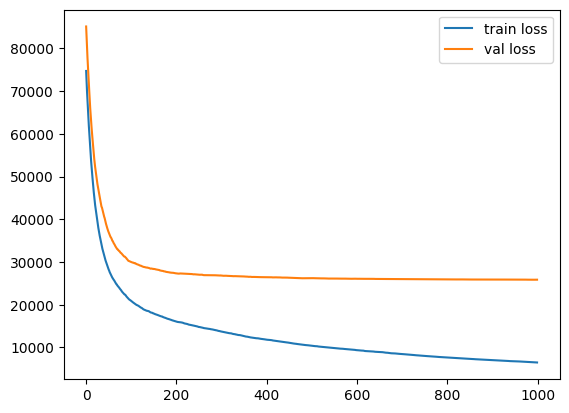

In [24]:
plt.plot(cb_imputed.get_evals_result()['learn']['RMSE'], label='train loss')
plt.plot(cb_imputed.get_evals_result()['validation']['RMSE'], label='val loss')
plt.legend()
plt.show()

In [25]:
print('Train set RMSE: {}\nTest set RMSE: {}'.format(cb_imputed.get_best_score()['learn']['RMSE'], 
                                                      cb_imputed.get_best_score()['validation']['RMSE']))

Train set RMSE: 6474.8605255541
Test set RMSE: 25839.835064388786


Top-10 important features plotted with barplot

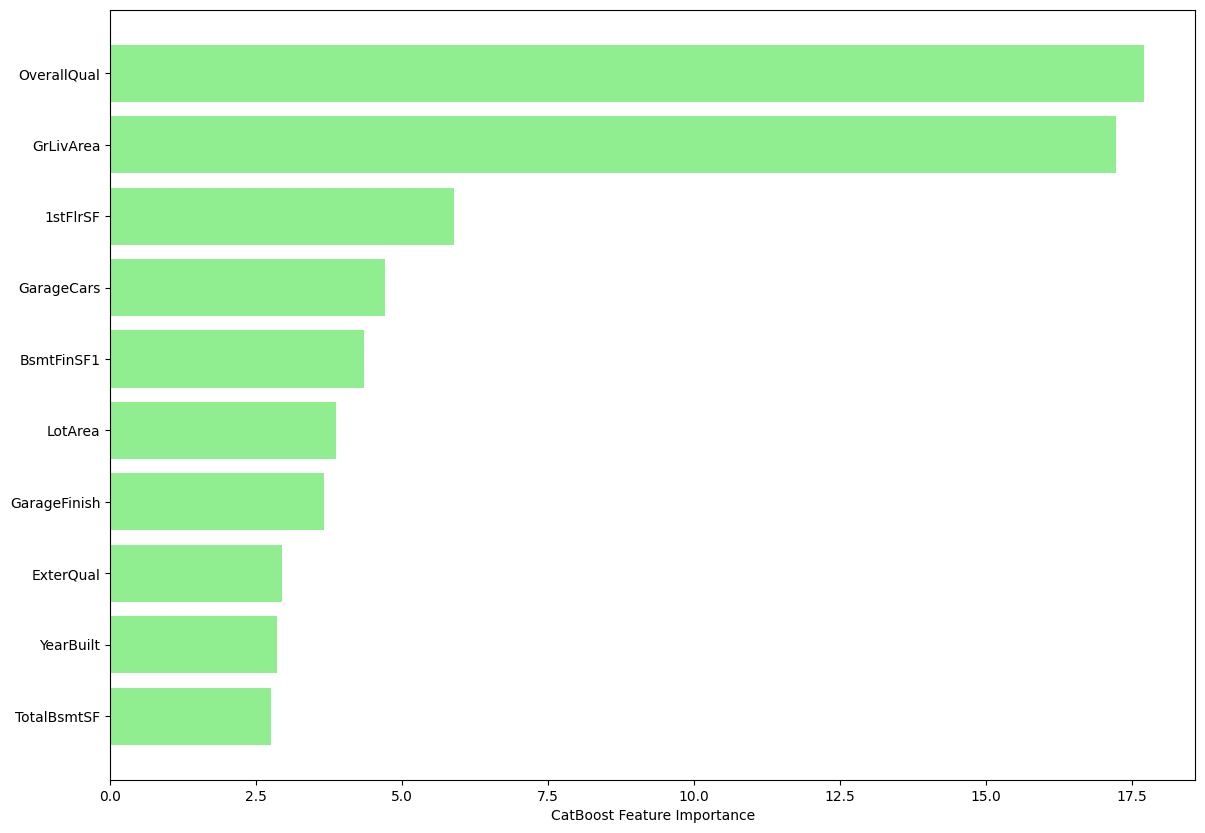

In [27]:
feature_importance_plot(cb_imputed, imputed_train_pool, n_features=10)

**Conclusions:**
- the quality metric for the training set has improved, but for the test set, on the contrary, it has worsened (possibly a slight overfitting)
- the distribution of the significance of features has changed significantly; Intuitively, the data obtained after algorithmically filling missing values is worse than simply filling missing values with the string 'NA'. But it would probably be worth looking deeper into the data